In [1]:
import os
import pytz
import pickle

import pandas as pd
import numpy as np
from collections import OrderedDict
from datetime import datetime, timedelta

from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
from matplotlib import style
style.use("seaborn-dark")

import warnings
warnings.filterwarnings('ignore')

data_path = "./Trial-assignment/data/market_data"
pickle_path = 'data_prices.pkl'

In [2]:
def remove_stock_splits(data, ticker):
    try:
        split_df = pd.read_csv('./Trial-assignment/data/div_data/{}.csv'.format(ticker))
        split_df = split_df[split_df['Dividend Type'] == 'Stock Split'].sort_values(by=['Ex-Date'], ascending=[False])
        for index, row in split_df.iterrows():
            div_dt = datetime.strptime(row['Ex-Date'], '%Y-%m-%d')
            data[ticker][div_dt: ] = data[ticker][div_dt: ] * row['Dividend Amount']
    except:
        pass
    return data

In [3]:
def create_prices_data(data_path, pickle_path):
    data = OrderedDict()

    for directory, dirnames, filenames in os.walk(data_path):
        for count, filename in enumerate(filenames):
            ticker = filename[:-4]
            data[ticker] = pd.read_csv('{}/{}.csv'.format(data_path, ticker), index_col=0, parse_dates=['dt'])
            data[ticker] = data[ticker].resample("1d").mean()
            data[ticker].fillna(method="ffill", inplace=True)
            data = remove_stock_splits(data, ticker)
            if count % 100 == 0:
                print(count)

    with open(pickle_path, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [4]:
%%time
create_prices_data(data_path, pickle_path)

0
100
200
300
400
500
600
CPU times: user 1min 29s, sys: 19 s, total: 1min 48s
Wall time: 2min 6s


In [5]:
%%time
with open(pickle_path, 'rb') as f:
    data = pickle.load(f)


CPU times: user 347 ms, sys: 18 ms, total: 365 ms
Wall time: 391 ms


In [6]:
data['SPY'].drop(['Adj Close'], axis=1, inplace=True)

In [7]:
def prepare_data_panel(data, start_backtest, end_backtest):
    valid_data = OrderedDict()
    for ticker, prices in data.items(): 
        has_rows = len(data[ticker][start_backtest:end_backtest])
        need_rows = (end_backtest - start_backtest).days + 1
        if has_rows and (has_rows == need_rows):
            valid_data[ticker] = prices
    panel = pd.Panel(valid_data)
    panel.minor_axis = ["open","high","low","close","volume"]
    panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
    return panel

In [8]:
import zipline
from zipline.api import (set_commission, 
                         symbol,
                         symbols,
                         set_symbol_lookup_date, 
                         set_slippage,
                         schedule_function,
                         date_rules,
                         time_rules,
                         set_benchmark,
                         order_target_percent)
from zipline.finance import slippage, commission


class Stat():
    
    def hurst(self, p, max_lags=100):
        lags = range(2, max_lags)
        variancetau = []; tau = []
        for lag in lags: 
            tau.append(lag)
            pp = np.subtract(p[lag:], p[:-lag])
            variancetau.append(np.sqrt(np.std(pp)))
        m = np.polyfit(np.log10(tau), np.log10(variancetau),1)
        hurst = m[0] / 2
        return hurst
    
    def half_life(self, price): 
        lagged_price = price.shift(1).fillna(method="bfill")  
        delta = price - lagged_price  
        beta = np.polyfit(lagged_price, delta, 1)[0] 
        half_life = (-1*np.log(2)/beta) 
        return half_life
    
    def hedge_ratio(self, Y, X, add_const=True):
        if add_const:
            X = sm.add_constant(X)
            model = sm.OLS(Y, X).fit()
            return model.params[1]
        model = sm.OLS(Y, X).fit()
        return model.params.values


class Pairs_Manager():
    
    def __init__(self, stat, target_pairs_cnt, max_missed_orders_cnt,
                 corr_threshold, adf_significance,
                 hurst_threshold, half_life_threshold):
        self.stat = stat
        self.pairs = []
        self.missed_orders_cnt = 0
        self.target_pairs_cnt = target_pairs_cnt
        self.max_missed_orders_cnt = max_missed_orders_cnt
        self.corr_threshold = corr_threshold
        self.adf_significance = adf_significance
        self.hurst_threshold = hurst_threshold
        self.half_life_threshold = half_life_threshold
        
    def _convert_ticker_str_to_equity(self, tickers):
        equities = []
        for ticker in tickers:
            try:
                equities.append(symbol(ticker))
            except Exception as e:
                pass
        return equities
    
    def _share_data_by_sectors(self, df):
        data = dict()
        sectors_df = pd.read_csv("./Trial-assignment/data/sectors.csv") 
        sectors = sectors_df['INDUSTRY_GROUP'].unique()
        for sector in sectors:
            tickers = sectors_df[sectors_df['INDUSTRY_GROUP'] == sector]['TICKER'].unique()
            tickers = self._convert_ticker_str_to_equity(tickers)
            tickers = set(tickers) & set(df.columns)
            tickers = list(tickers)
            if len(tickers) > 1:
                data[sector] = df[tickers]
        return data
    
    def _find_correlated_pairs(self, df, threshold=0.9):
        core = df.corr()
        c1 = core.abs().unstack()
        in_pairs = set()
        pairs = []
        for key, value in c1.items():
            if key[1] not in in_pairs and key[0] != key[1] and value >= threshold:
                in_pairs.add(key[0])
                pairs.append(key)
        return pairs
    
    def _coint_validate_pairs(self, data, candidates, significance=0.05):  
        pairs = []  
        for pair in candidates:
            S1 = data[pair[0]]  
            S2 = data[pair[1]]  
            result = coint(S1, S2)  
            pvalue = result[1]  
            if pvalue < significance:  
                pairs.append(pair) 
        return pairs

    def _hurst_validate_pairs(self, df, candidates, threshold=0.4):
        pairs = []  
        for pair in candidates:
            ticker_1 = pair[0]
            ticker_2 = pair[1]
            S1 = df[ticker_1]
            S2 = df[ticker_2]
            S1 = sm.add_constant(S1)
            results = sm.OLS(S2, S1).fit()
            S1 = S1[ticker_1]
            b = results.params[ticker_1]
            spread = S2 - b * S1
            h = self.stat.hurst(spread)
            if h < threshold:  
                pairs.append(pair) 
        return pairs

    def _half_life_validate_pairs(self, df, candidates, threshold=40.):
        pairs = []  
        for pair in candidates:
            ticker_1 = pair[0]
            ticker_2 = pair[1]
            S1 = df[ticker_1]
            S2 = df[ticker_2]
            S1 = sm.add_constant(S1)
            results = sm.OLS(S2, S1).fit()
            S1 = S1[ticker_1]
            b = results.params[ticker_1]
            spread = S2 - b * S1
            hl = self.stat.half_life(spread)
            if hl < threshold:  
                pairs.append(pair) 
        return pairs
    
    @property
    def num_pairs(self):
        return len(self.pairs)
    
    def find_pairs(self, price_data):
        self.missed_orders_cnt = 0
        data_with_sector = self._share_data_by_sectors(price_data)
        self.pairs = []
        pairs_list = []
        pairs_dict = dict()
        for sector, df in data_with_sector.items():
            pairs = self._find_correlated_pairs(df, self.corr_threshold)
            pairs = self._coint_validate_pairs(df, pairs, self.adf_significance)
            pairs = self._hurst_validate_pairs(df, pairs, self.hurst_threshold)
            pairs = self._half_life_validate_pairs(df, pairs, self.half_life_threshold)
            pairs_dict[sector] = pairs
            pairs_list.extend(pairs)
                
        pair_keys = set()
        for pair in pairs_list:
            if pair[0] not in pair_keys and pair[1] not in pair_keys:
                pair_keys.add(pair[0])
                pair_keys.add(pair[1])
                self.pairs.append(pair)
        self.pairs = self.pairs[:self.target_pairs_cnt]
        
    def need_refresh(self):
        return (self.num_pairs == 0 or 
                    self.missed_orders_cnt >= self.max_missed_orders_cnt)
        
            
            
class Portfolio_Manager():
    
    def __init__(self, pairs_manager):
        self.pairs_manager = pairs_manager
        self.inLong = [False] * self.pairs_manager.num_pairs
        self.inShort = [False] * self.pairs_manager.num_pairs
        self.target_weights = {}
        
    def close_position(self, pair_number, stock_y, stock_x):
        self.target_weights[stock_y] = 0
        self.target_weights[stock_x] = 0
        self.inShort[pair_number] = False
        self.inLong[pair_number] = False
        
    def open_position(self, pair_number, 
                      inLong, inShort, 
                      y_target_shares, x_target_shares, 
                      y_price, x_price,
                      stock_y, stock_x):
        self.inShort[pair_number] = inShort
        self.inLong[pair_number] = inLong

        (y_target_pct, x_target_pct) = self._computeHoldingsPct(y_target_shares,
                                                                x_target_shares,
                                                                y_price, 
                                                                x_price)
        
        self.target_weights = self._rebalance_weights(stock_y,
                                                      stock_x, 
                                                      y_target_pct, 
                                                      x_target_pct) 
        
    def allocate(self):    
        for stock, weight in self.target_weights.items():
            order_target_percent(stock, weight)
            
    def close_all_positions(self):
        for stock, weight in self.target_weights.items():
            order_target_percent(stock, 0.)
        
    def _computeHoldingsPct(self, yShares, xShares, yPrice, xPrice):
        yDol = yShares * yPrice
        xDol = xShares * xPrice
        notionalDol =  abs(yDol) + abs(xDol)
        y_target_pct = yDol / notionalDol
        x_target_pct = xDol / notionalDol
        return (y_target_pct, x_target_pct)
    
    def _get_holdings_cnt(self):
        holdings_cnt = 0.
        for k, w in self.target_weights.items():
            if abs(w) > 0.:
                holdings_cnt += 1
        holdings_cnt /= 2.
        return holdings_cnt
    
    def _mult_target_weights(self, target_weights, mult):
        weights = {}
        for k, w in target_weights.items():
            weights[k] = w * mult
        return weights
 
    def _rebalance_weights(self, stock_y, stock_x, y_target_pct, x_target_pct):
        holdings_cnt = self._get_holdings_cnt()
        self.target_weights = self._mult_target_weights(self.target_weights, holdings_cnt)
        self.target_weights[stock_y] = y_target_pct
        self.target_weights[stock_x] = x_target_pct
        holdings_cnt = self._get_holdings_cnt()
        self.target_weights = self._mult_target_weights(self.target_weights, 1 / holdings_cnt)
        return self.target_weights
        
        

def initialize(context):
    set_slippage(slippage.FixedSlippage(spread=0))
    set_commission(commission.PerTrade(cost=1))
    set_symbol_lookup_date('2018-01-01')
#     set_benchmark(symbol("SPY"))
    context.stat = Stat()
    context.pairs_manager = Pairs_Manager(stat=context.stat,
                                          corr_threshold=0.9,
                                          adf_significance=0.01,
                                          hurst_threshold=0.3,
                                          half_life_threshold=5.,
                                          target_pairs_cnt=4,
                                          max_missed_orders_cnt=10)
    context.portf_manager = Portfolio_Manager(context.pairs_manager)
    window = 120
    context.windows = {
        'hedge_window': window,
        'z_window': 30,
        'hist_window': window,
        'coint_window': window,      
    }
    
    schedule_function(func=check_pair_status,
                      date_rule=date_rules.every_day(),
                      time_rule=time_rules.market_close(minutes=30))
    
    
def handle_data(context, data):
    pass


def check_pair_status(context, data):

    prices = data.history(data.keys(), 'price', context.windows['hist_window'], '1d')    

    context.pairs_manager.missed_orders_cnt += 1
    
    if context.pairs_manager.need_refresh():
        context.pairs_manager.find_pairs(prices)
#         print(context.pairs_manager.pairs)
        context.portf_manager.close_all_positions()
        context.portf_manager = Portfolio_Manager(context.pairs_manager)
    
    for i in range(context.pairs_manager.num_pairs):

        (stock_y, stock_x) = context.pairs_manager.pairs[i]

        Y = prices[stock_y]
        X = prices[stock_x]
        
        try:
            hedge = context.stat.hedge_ratio(
                Y.iloc[-context.windows['hedge_window']::],
                X.iloc[-context.windows['hedge_window']::],
                add_const=True)      
        except ValueError as e:
            log.debug(e)
            return

        spread = Y - hedge * X
        z_spread = spread.iloc[-context.windows['z_window']::]
        spread_mavg1 = pd.rolling_mean(z_spread, window=1)
        
        zscore = (spread_mavg1[-1] - z_spread.mean()) / z_spread.std()
        
        coint_spreads = spread.iloc[-context.windows['coint_window']::]
        result = adfuller(coint_spreads)
        pvalue = result[1]
        coint = pvalue < 0.2

        coint = True
        if not coint:
            context.portf_manager.close_position(i, stock_y, stock_x)

        if context.portf_manager.inShort[i] and zscore < 0.0:
            context.portf_manager.close_position(i, stock_y, stock_x)

        elif context.portf_manager.inLong[i] and zscore > 0.0:
            context.portf_manager.close_position(i, stock_y, stock_x)

        elif zscore < -1.0 and (not context.portf_manager.inLong[i]):
            context.portf_manager.open_position(
                      i, 
                      inLong=True, inShort=False, 
                      y_target_shares=1, x_target_shares=-hedge, 
                      y_price=Y[-1], x_price=X[-1],
                      stock_y=stock_y, stock_x=stock_x)

        elif zscore > 1.0 and (not  context.portf_manager.inShort[i]):
            context.portf_manager.open_position(
                      i, 
                      inLong=False, inShort=True, 
                      y_target_shares=-1, x_target_shares=hedge, 
                      y_price=Y[-1], x_price=X[-1],
                      stock_y=stock_y, stock_x=stock_x)
            
    context.portf_manager.allocate() 
    

In [9]:
%%time
start_backtest = datetime(2017, 1, 1, 0, 0, 0, 0, pytz.utc)
end_backtest = datetime(2018, 2, 1, 0, 0, 0, 0, pytz.utc)
panel = prepare_data_panel(data, start_backtest, end_backtest)

print('panel prepared. run algorithm')
perf = zipline.run_algorithm(
                      start=start_backtest,
                      end=end_backtest,
                      initialize=initialize,
                      capital_base=10000,
                      handle_data=handle_data,
                      data=panel)

panel prepared. run algorithm
CPU times: user 2min 32s, sys: 15.7 s, total: 2min 48s
Wall time: 2min 32s


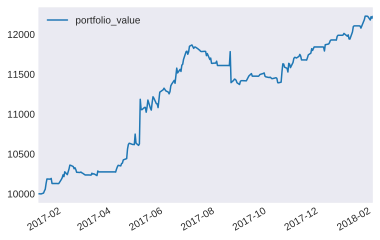

In [10]:
perf['portfolio_value'].plot(label="portfolio_value", legend=True)

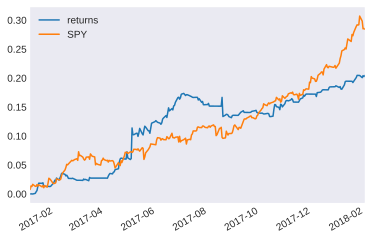

In [11]:
perf['returns'].cumsum().plot(label="returns", legend=True)
perf['benchmark_period_return'].plot(label="SPY", legend=True)

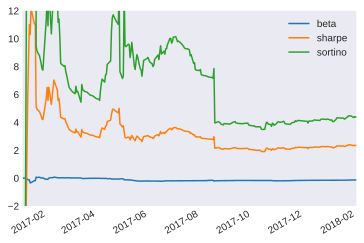

In [14]:
perf['beta'].plot(label="beta", legend=True, ylim=(-2, 12))
perf['sharpe'].plot(label="sharpe", legend=True)
perf['sortino'].plot(label="sortino", legend=True)